# Mean Variance Analysis

## Summary

### Mean-variance Portfolio Framework

Assumptions:
* Investors only care about means and variances.
* Investors are risk averse.

Mean-variance optmization will find you a portfolio that has the highest Sharpe ratio:

$$
SR \equiv \frac{\mathbb{E}\left[r\right]-r_f}{\sigma_{r-r_f}}
$$

Steps to find the optimal portfolio:
1. Construct the minimum-variance frontier using risky asssts only.
2. Find the tangency portfolio, i.e. portfolio of risky assets with the highest Sharpe ratio.
3. Combine the tangency portfolo with the risk-free asset.
4. Choose the final portfolio depending on your risk aversion.

## Reference

Chapter 3 of Andrew Ang, Asset Management: A Systematic Approach to Factor Investing.

## Quantopian Implementation

In this first notebook, we'll start to work with Quantopian and Python. This first problem set helps us to construct the efficient frontier and the capital market line. 

We proceed in five steps:
1. Initialize Python. There are some basic lines of code that we always add. 
2. We download returns on two securities: Amazon (ticker: AMZN) and Goldman Sachs (ticker: GS).
3. We compute the returns of portfolios that combine the two securities with different weights.
4. We compute the means and variances of the portfolio returns from step 3, leading to the efficient frontier.
5. We compute the capital market line (CML) by combining the risk-free rate (which we set to zero, consistent with the short-term interest rate in today's financial markets) and the efficient portfolio.

Let's get started!

Step 1: Initializing Python.

Python uses libraries with pre-coded functions that make it really easy to compute all the statistics we need, such as means, variances, et cetera. In this problem set, we use the following three lines. Now run this first block. If this works, the message "Python is ready to go!" appears.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print "Python is ready to go!"

Python is ready to go!


Step 2: Downloading data.

Let's download the data. I first provide an example for Apple. The following two lines of code download the data for Apple (ticker: AAPL). This lines creates a table with dates in the rows. In the first column, we have the date and in the second column the price. The price is adjusted for splits, dividend payments, ... In historical tests, we always use this price variable (instead of, for instance, the close price).

At any point, you can see what's in the table by printing the first couple of lines by the command
"print AAPL.head()". The default is 5. If you'd like to see more lines, let's say 10 lines, you can use "print AAPL.head(10)". Similarly, if you'd like to see the last lines, you use "AAPL.tail()".

In [2]:
AAPL = get_pricing('AAPL', start_date='2007-1-1', end_date='2018-1-24', fields="price")
print AAPL.head()

2007-01-03 00:00:00+00:00    10.732
2007-01-04 00:00:00+00:00    10.967
2007-01-05 00:00:00+00:00    10.896
2007-01-08 00:00:00+00:00    10.944
2007-01-09 00:00:00+00:00    11.852
Freq: C, Name: Equity(24 [AAPL]), dtype: float64


Note that this line of code only gets the prices from days that markets are opened. Hence, weekends and holidays are removed already.

Let's plot the price index. The first line of code constructs the graph. The next three lines provide the labels for the axes and defines the legend.

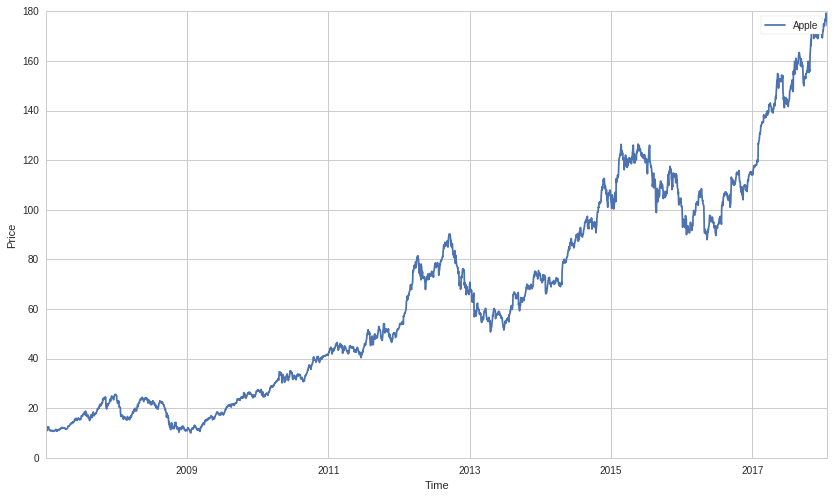

In [3]:
plt.plot(AAPL.index, AAPL.values)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(['Apple']);

Next, we want to compute returns. Given that we have a total return index (that is, prices already include dividends), we compute returns as R(t) = P(t)/P(t-1)-1. The code "AAPL.shift(1)" shifts the data one day backwards.

In [4]:
AAPL_ret = AAPL/AAPL.shift(1)-1

print AAPL_ret.head(3)

2007-01-03 00:00:00+00:00         NaN
2007-01-04 00:00:00+00:00    0.021897
2007-01-05 00:00:00+00:00   -0.006474
Freq: C, Name: Equity(24 [AAPL]), dtype: float64


As you can see, we created a missing value (NaN) for the first observation. After all, we do not have the price before January 3, 2007. To get rid of it, we can start our return series 1 day later and drop the first observation. In Python, the index of a table starts at 0. Hence, we want to start our data from index 1. The code 
"AAPL_ret = AAPL_ret[1:]"
selects all data starting at the second observation. Let's try it:

In [5]:
AAPL_ret = AAPL_ret[1:]
print AAPL_ret.head(3)

2007-01-04 00:00:00+00:00    0.021897
2007-01-05 00:00:00+00:00   -0.006474
2007-01-08 00:00:00+00:00    0.004405
Freq: C, Name: Equity(24 [AAPL]), dtype: float64


There is a more efficient way to compute returns now that we understand the mechanics. The following line of code computes the percent difference, just like we did before, and drops the first observation:

In [6]:
AAPL_ret = AAPL.pct_change()[1:]
print AAPL_ret.head(3)

2007-01-04 00:00:00+00:00    0.021897
2007-01-05 00:00:00+00:00   -0.006474
2007-01-08 00:00:00+00:00    0.004405
Freq: C, Name: Equity(24 [AAPL]), dtype: float64


We're now ready for the first part of our problem set. In the box below, write the following code:
1. Download the data for the two stocks in two variables, called AMZN and GS.
2. Compute the returns in AMZN_ret and GS_ret and drop the first observation.

==> Q1: Report the first three prices of Amazon and Goldman (January 3, 4, and 5 2007).

In [7]:
AMZN = get_pricing('AMZN', start_date='2007-1-1', end_date='2018-1-24', fields="price")
GS   = get_pricing('GS', start_date='2007-1-1', end_date='2018-1-24', fields="price")

In [10]:
print AMZN.values[0:3]
print GS.values[0:3]

[ 38.7   38.91  38.37]
[ 175.503  174.28   174.329]


Now let's plot the price series of both stocks. If all variables are computed correctly, you can run the plot below. 

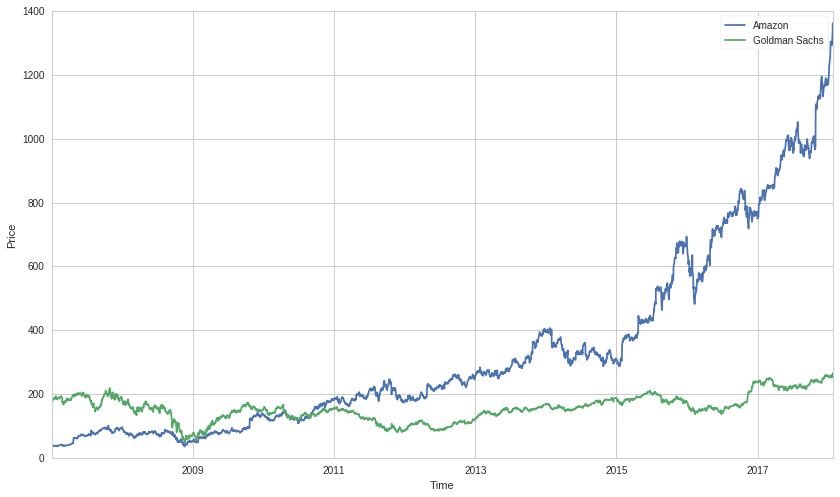

In [8]:
plt.plot(AMZN.index, AMZN.values, GS.index, GS.values)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(['Amazon','Goldman Sachs']);

==> Q2: Save the figure in your problem set.

Next, we want to combine both securities into a portfolio and find the efficient frontier. Here, we use a trick called "loops." Instead of manually computing lots of different combinations of the portfolio, we can use just a couple of lines of code to do this for us.

Let's consider a simple example of a loop. Suppose we want to consider 3 portfolios: (100%,0%), (50%,50%), and (0%, 100%). We can do this via:

In [11]:
for w in xrange(0,3):
    weight = w * 0.5
    print weight

0.0
0.5
1.0


The first line tells us the values w will take. In this case, 0, 1, and 2. Then we define the weight in steps of 50%. The last line, like we have seen before, prints the value of the portfolio weight.

There is an important note here: The loop executes all lines that are indented. If they're not indented, they'll not be executed as part of the loop.

Next, we want to compute the portfolio return in each step of the loop. The return on the portfolio is:

"return_portfolio = weight * AMZN_ret + (1-weight) * GS_ret"

That is, we take the weighted average of both returns. 

Once we have the portfolio return, we want to compute the mean and the standard deviation. Remember we started with the first couple of lines of code? We need these packages now. Pyhton has lots of useful functions already programmed for you (just like Excel). We now want to know the mean and the standard deviation of our portfolio.

The mean is computed as np.mean() and the standard deviation as np.std(). We put them together in a row of a table with the portfolio weight first.

for w in xrange(0,3):
    weight = w * 0.5
    return_portfolio = weight * AMZN_ret + (1-weight) * GS_ret
    print [weight, np.mean(return_portfolio), np.std(return_portfolio)]

Instead of printing each line, we'd like to store the results in a table so we plot it easily. We can do this using the "append" command. We start from two empty tables (portfolio_mean and portfolio_std). Then in every iteration of the loop, we add the mean and standard deviation, respectively.

In [13]:
AMZN_ret = AMZN/AMZN.shift(1)-1
AMZN_ret = AMZN_ret[1:]
GS_ret   = GS/GS.shift(1)-1
GS_ret   = GS_ret[1:]

In [14]:
portfolio_mean = []
portfolio_std = []

for w in xrange(0,3):
    weight = w * 0.5
    return_portfolio = weight * AMZN_ret + (1-weight) * GS_ret
    portfolio_mean.append(np.mean(return_portfolio))
    portfolio_std.append(np.std(return_portfolio))

Now let's plot the minimum-variance frontier! 

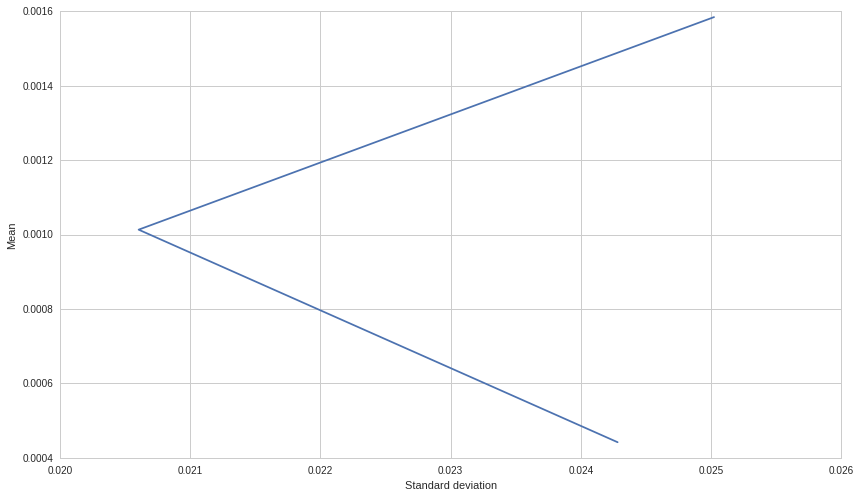

In [15]:
plt.plot(portfolio_std, portfolio_mean)
plt.xlabel('Standard deviation')
plt.ylabel('Mean');

That starts to look like a minimum-variance frontier. However, as we only compute 3 portfolios, the line doesn't look very smooth. So let's now take steps of 5%. In the box below, adjust the code so that the loop takes steps from 0%, 5%, ..., 100%.

In [16]:
portfolio_mean = []
portfolio_std = []

for w in xrange(0,21):
    weight = w * 0.05
    return_portfolio = weight * AMZN_ret + (1-weight) * GS_ret
    portfolio_mean.append(np.mean(return_portfolio))
    portfolio_std.append(np.std(return_portfolio))

If this all worked out, the code below should give you a smooth efficient frontier.

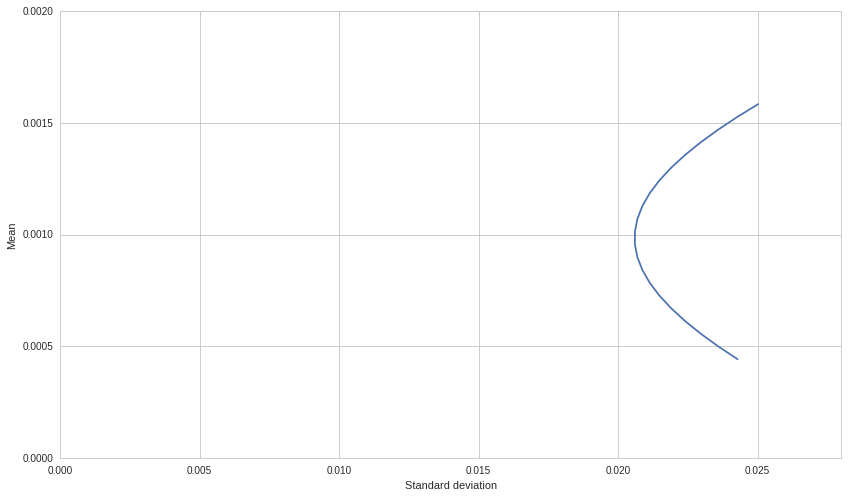

In [17]:
plt.plot(portfolio_std, portfolio_mean)
plt.xlabel('Standard deviation')
plt.ylabel('Mean')
plt.axis([0, 0.028, 0, 0.002]);   

==> Q3: Copy the plot of the efficient frontier to your problem set. 

However, you can see that the curve abruptly ends. We need to short a stock to complete the curve. We can do this by extending the loop. Below the code for weights ranging from (-100%,200%), (-90%,190%), ..., (200%,-100%). Hence, each portfolio adds up to 100%. The code below does exactly that.

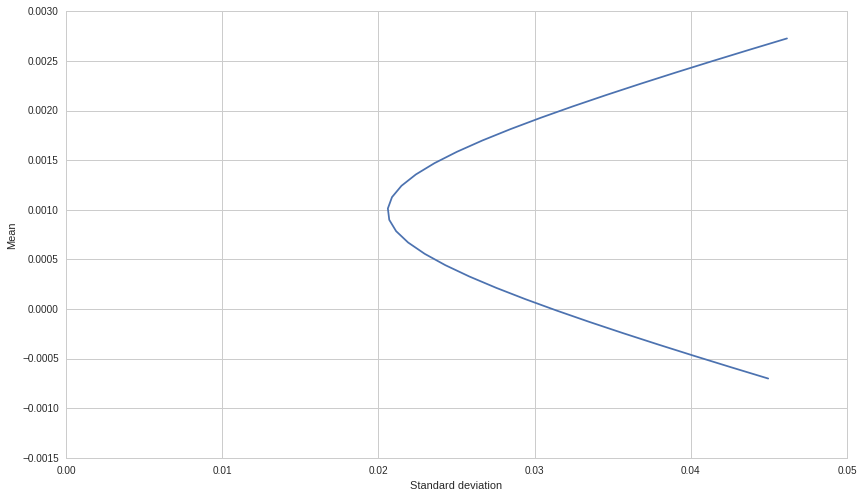

In [18]:
portfolio_mean = []
portfolio_std = []

for w in xrange(0,31):
    weight = w * 0.10 - 1
    return_portfolio = weight * AMZN_ret + (1-weight) * GS_ret
    portfolio_mean.append(np.mean(return_portfolio))
    portfolio_std.append(np.std(return_portfolio))
    
plt.plot(portfolio_std, portfolio_mean)
plt.xlabel('Standard deviation')
plt.ylabel('Mean')
plt.axis([0, 0.05, -0.0015, 0.003]);       

Lastly, we want to construct the capital market line. The capital market line combines the risk-free rate (zero in this problem set) and the combination of both stocks with the highest possible Sharpe ratio. Recall that the Sharpe ratio is defined as (E(r)-rf) / stdev(r). So let's add the Sharpe ratio to the loop.

The last line selects the portfolio that maximizes the Sharpe ratio.

In [19]:
portfolio_mean = []
portfolio_std = []
portfolio_weight = []
portfolio_SR = []

for w in xrange(0,31):
    weight = w * 0.10 - 1
    return_portfolio = weight * AMZN_ret + (1-weight) * GS_ret
    portfolio_mean.append(np.mean(return_portfolio))
    portfolio_std.append(np.std(return_portfolio))
    portfolio_weight.append(weight)
    portfolio_SR.append(np.mean(return_portfolio)/np.std(return_portfolio))

The table portfolio_SR contains the Sharpe ratio of each portfolio. Let's plot it to see what it looks like.

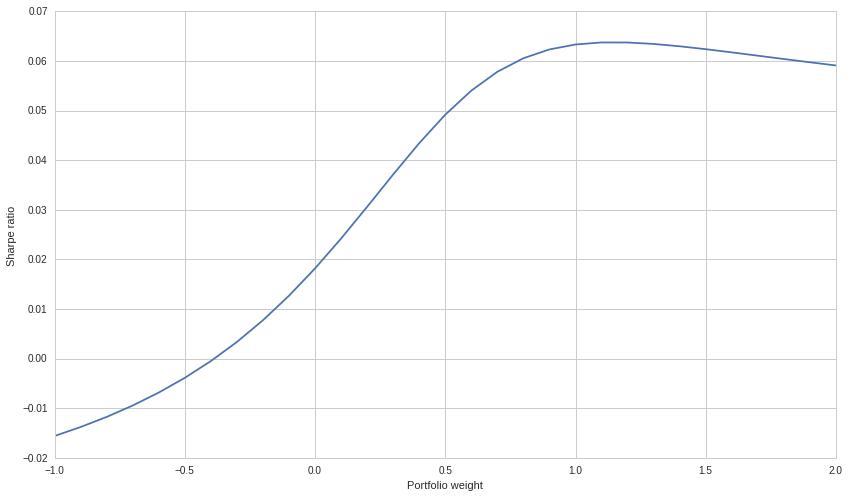

In [20]:
plt.plot(portfolio_weight, portfolio_SR)
plt.xlabel('Portfolio weight')
plt.ylabel('Sharpe ratio');

Now instead of reading off the figure what the efficient portfolio is, let's do this using Python. 

The code
"portfolio_SR.index(max(portfolio_SR))" 

returns the line of the table that contains the maximum Sharpe ratio. Then we look up in the table "portfolio_weight" what the corresponding weight is.



In [21]:
SR_maximum = max(portfolio_SR)
print "Optimal portfolio weight:", portfolio_weight[portfolio_SR.index(SR_maximum)]

Optimal portfolio weight: 1.1


To complete this exercise, we plot the capital market line.

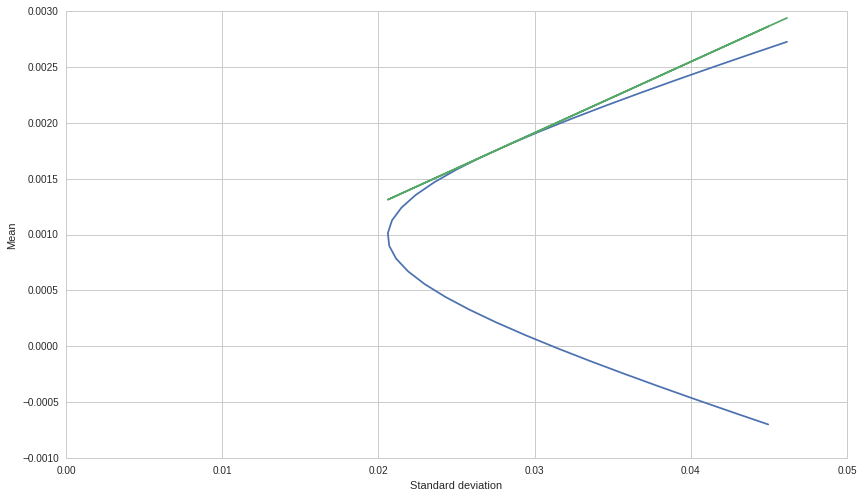

In [22]:
portfolio_mean = []
portfolio_std = []
mean_CML = []

for w in xrange(0,31):
    weight = w * 0.10 - 1
    return_portfolio = weight * AMZN_ret + (1-weight) * GS_ret
    portfolio_mean.append(np.mean(return_portfolio))
    portfolio_std.append(np.std(return_portfolio))
    mean_CML.append(SR_maximum * np.std(return_portfolio))
    
plt.plot(portfolio_std, portfolio_mean,portfolio_std,mean_CML)
plt.xlabel('Standard deviation')
plt.ylabel('Mean')
plt.axis([0, 0.05, -0.001, 0.003]);     